In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Data Source:

UCI Machine Learning Repository - Seoul Bike Sharing Demand - https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
cd /drive/MyDrive/'Colab Notebooks'

/drive/MyDrive/Colab Notebooks


In [4]:
ls

magic04.data  SeoulBikeData.csv  Supervised_Learning_01.ipynb  Supervised_Learning_02.ipynb


In [5]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']
# Remove unnecessary characters from the original file before uploading
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis =1)

In [6]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis=1)

In [7]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


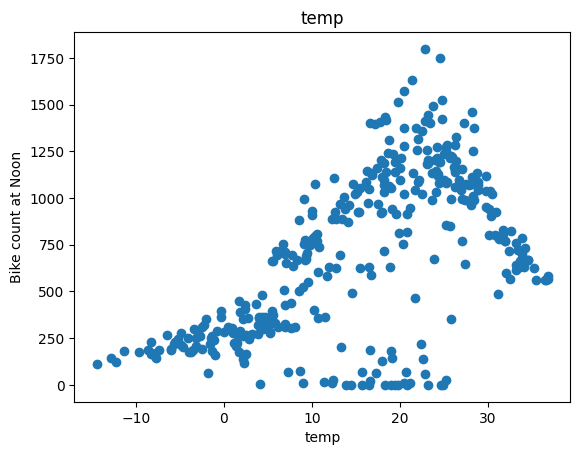

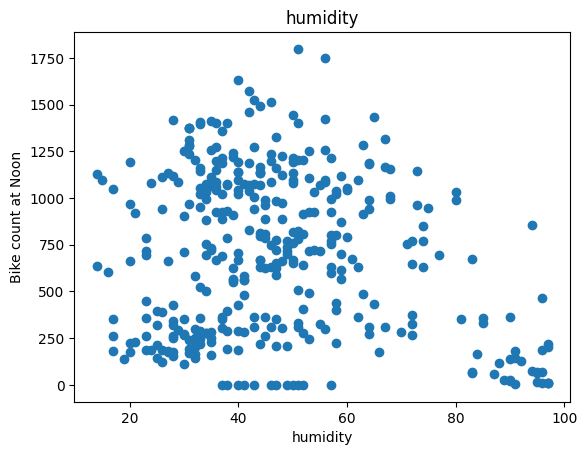

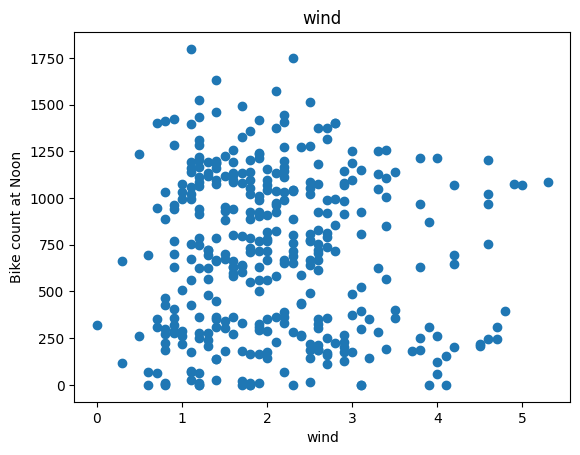

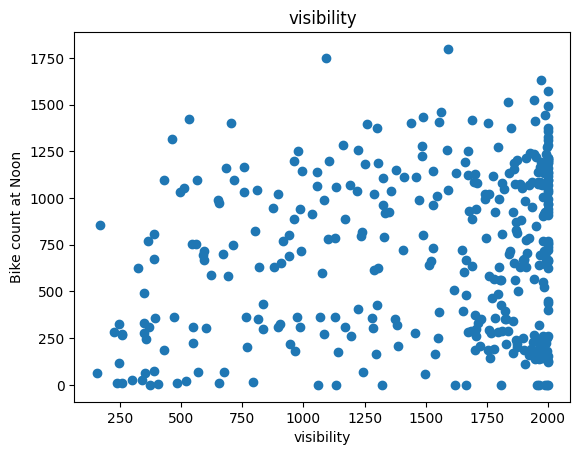

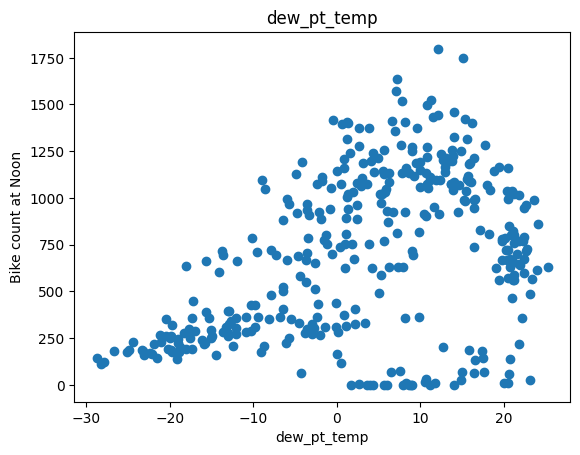

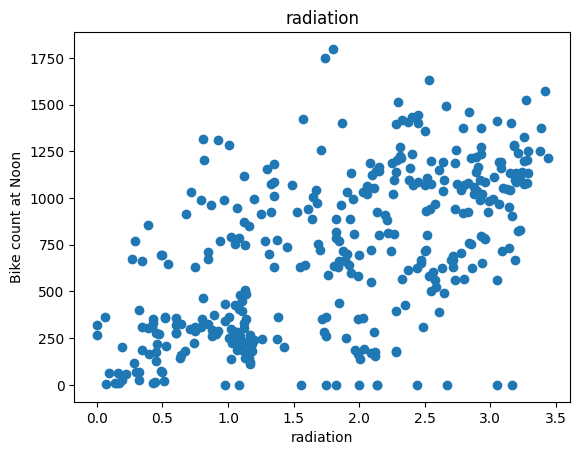

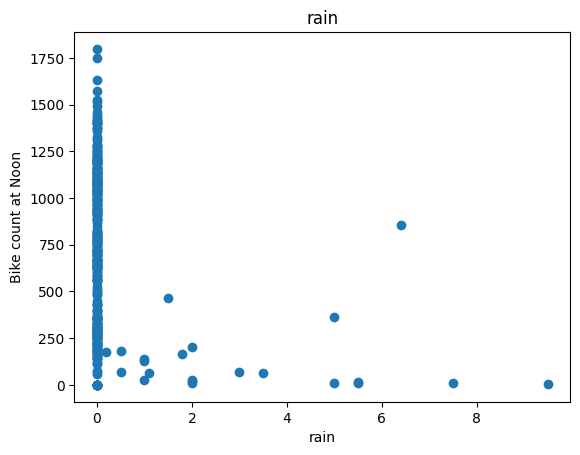

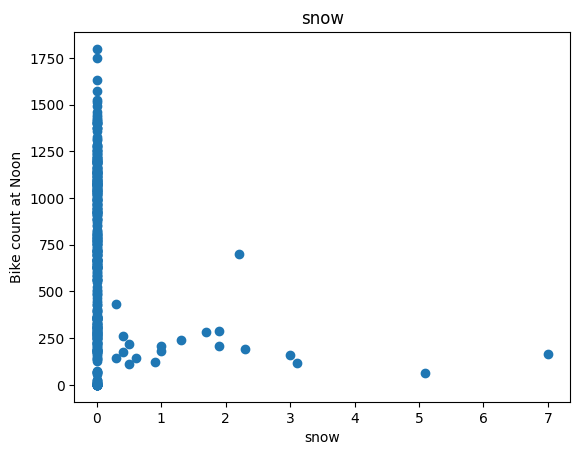

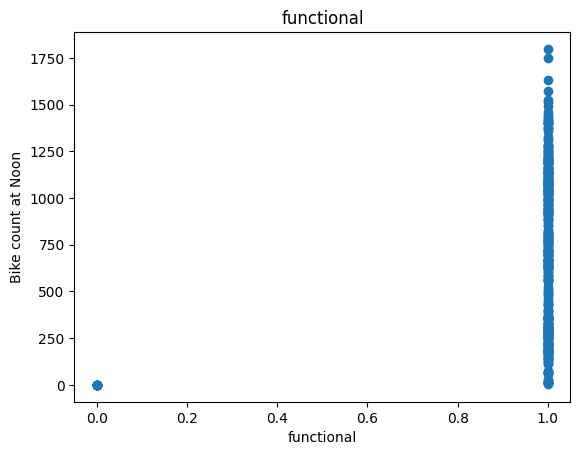

In [8]:
for label in df.columns[1:]:
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel('Bike count at Noon')
  plt.xlabel(label)
  plt.show()


In [9]:
df = df.drop(['wind', 'visibility', 'snow'], axis =1)

In [10]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,functional
12,449,1.7,23,-17.2,1.11,0.0,1
36,479,4.3,41,-7.8,1.09,0.0,1
60,333,5.8,85,3.4,0.43,0.0,1
84,393,-0.3,38,-12.9,1.11,0.0,1
108,321,-2.3,25,-19.7,0.00,0.0,1


#Train/Valid/test dataset

In [11]:
train, val, test = np.split(df.sample(frac=1), [ int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1 :
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X, y


In [13]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [14]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [15]:
print(temp_reg.coef_, temp_reg.intercept_)

[[19.73389692]] [369.43885533]


In [16]:
print(temp_reg.score(X_test_temp, y_test_temp))

0.3316573354713267


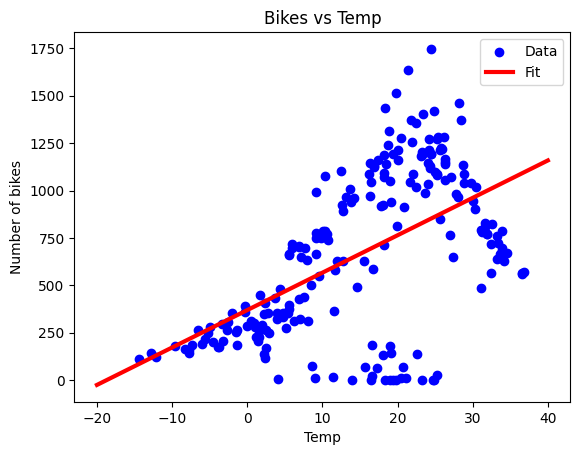

In [17]:
plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')
x = tf.linspace(-20,40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label = 'Fit', color='Red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

#Multiple Linear Regression

In [18]:
train, val, test = np.split(df.sample(frac=1), [ int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bike_count', df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', df.columns[1:])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
reg_all = LinearRegression()
reg_all.fit(X_train_all, y_train_all)

LinearRegression()

In [20]:
print(reg_all.score(X_test_all, y_test_all))

0.5816066033066014


#Regression with Neural Net

In [21]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [23]:
temp_nn_model.compile(tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [54]:
history=temp_nn_model.fit(
    X_train_temp.reshape(-1),y_train_temp, #reshape?
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp,y_val_temp)
)

In [63]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

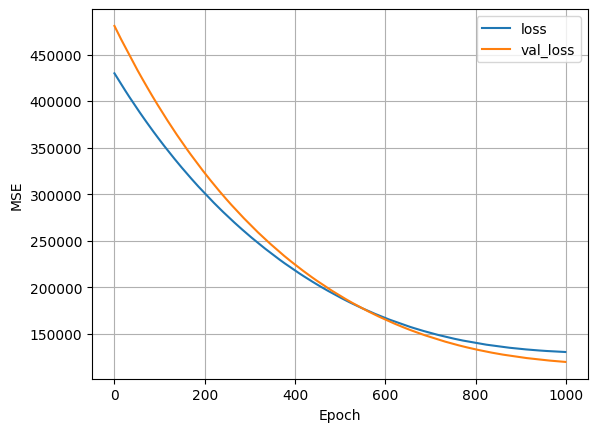

In [37]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


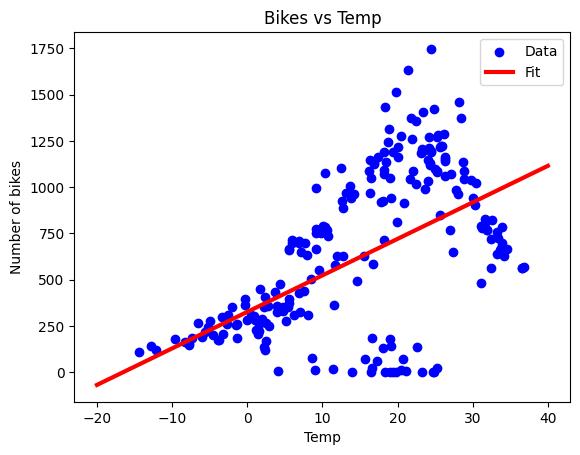

In [38]:
plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')
x = tf.linspace(-20,40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label = 'Fit', color='Red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

#Regression with Neural Net - multiple variables

In [40]:
X_train_all.shape

(219, 6)

In [41]:
reg_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
reg_normalizer.adapt(X_train_all.reshape(-1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
reg_nn = tf.keras.Sequential([
    reg_normalizer,
    tf.keras.layers.Dense(1)
])

In [45]:
reg_nn.compile(tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [47]:
history = reg_nn.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_all,y_val_all)
)

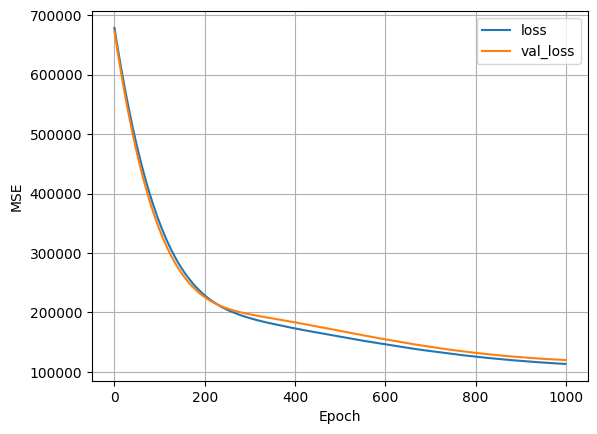

In [48]:
plot_loss(history)

#Neural Net

In [61]:
reg_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
reg_normalizer.adapt(X_train_all.reshape(-1))
reg_model=tf.keras.Sequential([
    reg_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
reg_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
history = reg_model.fit(
    X_train_all, y_train_all,
    verbose=0, epochs=1000,
    validation_data=(X_val_all,y_val_all)
)

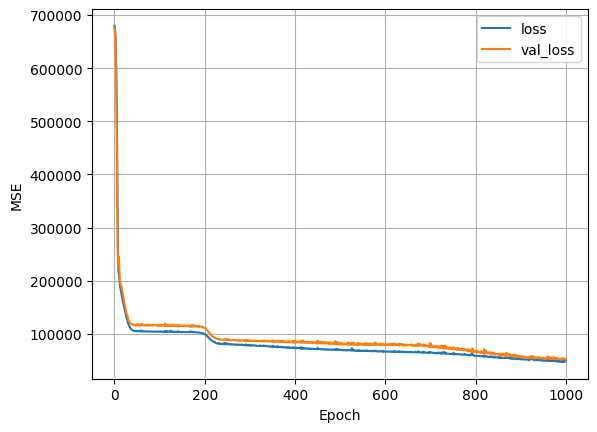

In [62]:
plot_loss(history)

In [65]:
y_pred_lr = reg_all.predict(X_test_all)
y_pred_nn = reg_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [66]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [68]:
MSE(y_pred_lr, y_test_all)

76753.83177955722

In [69]:
MSE(y_pred_nn, y_test_all)

57688.07360520418

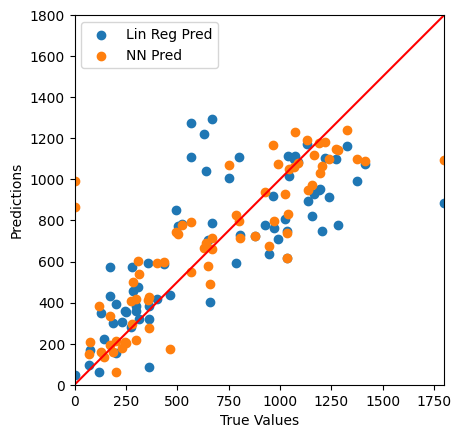

In [74]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label='Lin Reg Pred')
plt.scatter(y_test_all, y_pred_nn, label='NN Pred')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')